In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import time
import os

# Set up matplotlib
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

# Check available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs found: {num_gpus}")

def to_onehot(x, n):
    x_onehot = np.zeros((len(x), n), dtype=np.int64)
    for i in range(len(x)):
        x_onehot[i, x[i]] = 1
    return x_onehot

def corr_finder(hidden_all, test_trials, tr_len, hidden_size):    
    hidden_all = hidden_all.cpu().detach().numpy()
    test0 = np.where(test_trials==0)[0]
    test0_act = np.zeros((tr_len, hidden_size, len(test0)))
    count = 0
    for i in test0:
        test0_act[:,:,count] = hidden_all[i*tr_len: (i+1)*tr_len,:]
        count = count + 1

    test1 = np.where(test_trials==1)[0]
    test1_act = np.zeros((tr_len, hidden_size, len(test1)))
    count = 0
    for i in test1:
        test1_act[:,:,count] = hidden_all[i*tr_len: (i+1)*tr_len,:]
        count = count + 1
    corrplot = np.corrcoef(np.mean(test0_act, axis=2), np.mean(test1_act, axis=2))
    return corrplot

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_ih = nn.Parameter(torch.Tensor(hidden_size, input_size), requires_grad=True)
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

    def forward(self, x, hidden):
        feedforward_input = torch.mm(x.unsqueeze(0), self.W_ih.t())
        recurrent_input = torch.mm(hidden.unsqueeze(0), self.W_hh.t())
        
        new_hidden = torch.sigmoid(feedforward_input + recurrent_input)
    
        return new_hidden.squeeze(0)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn_cell = RNNCell(input_size, hidden_size)
        
        suggested_hh = torch.tensor(np.random.normal(0, 0.001, (hidden_size, hidden_size)), dtype=torch.float32)
        suggested_ih = torch.tensor(np.random.normal(0, 0.001, (hidden_size, input_size)), dtype=torch.float32)
        self.rnn_cell.W_ih.data = suggested_ih
        self.rnn_cell.W_hh.data = suggested_hh
        
        self.fc = nn.Linear(hidden_size, output_size, bias=False)
        self.fc.weight.data = torch.tensor(np.random.normal(0, 0.01, (output_size, hidden_size)), dtype=torch.float32)
        for param in self.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        hidden_state = torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)

        hidden_state[0,:] = self.rnn_cell(x[0, :], torch.zeros(self.rnn_cell.hidden_size, dtype=x.dtype, device=x.device))

        for t in range(1, x.size(0)):
            hidden_state[t,:] = self.rnn_cell(x[t, :], hidden_state[t-1,:].clone())
  
        out = self.fc(hidden_state)
        
        return out, hidden_state

def run_simulation(gpu_id, seeds, shared_dict):
    torch.cuda.set_device(gpu_id)
    device = torch.device(f"cuda:{gpu_id}")
    
    trial1x = np.array([1,1,1,1,1,1,2,2,2,2,1,1,1,4,6,1,1,1,5,5,1,1,0])
    trial2x = np.array([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,6,1,1,0])

    num_trials = 100
    num_trials_train = 50
    tr_len = len(trial1x)
    OBS = len(np.unique(np.concatenate((trial1x, trial2x))))
    input_size = OBS
    hidden_size = 1000
    output_size = OBS
    epochs = 1200
    save_each = 10

    loss_all = np.zeros((len(seeds), int(epochs/save_each)))
    corr_curve = np.zeros((len(seeds), int(epochs/save_each), tr_len*2, tr_len*2))
    accuracy_curve_all_test = np.zeros((len(seeds), int(epochs/save_each)))

    for idx, seed in enumerate(seeds):
        print(f'GPU {gpu_id}: Starting simulation {idx+1}/{len(seeds)} with seed {seed}')
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        rnn = RNN(input_size, hidden_size, output_size).to(device)
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(rnn.parameters(), lr=0.002)
        
        total_train_time = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            found_trials = False
            while not found_trials:
                trials = np.random.choice(2, num_trials)
                if np.sum(trials[:-1]==1)>1 and np.sum(trials[:-1]==0)>1:
                    found_trials = True
            x = np.zeros(num_trials*tr_len, dtype=np.int64)

            for trial in range(len(trials)):
                if trials[trial] == 0:
                    x[trial*tr_len: (trial+1)*tr_len] = trial1x
                else:
                    x[trial*tr_len: (trial+1)*tr_len] = trial2x

            x = to_onehot(x, OBS)
            
            train_x = torch.tensor(x[0:num_trials_train*tr_len], dtype=torch.float32).to(device)
            test_x = torch.tensor(x[num_trials_train*tr_len:], dtype=torch.float32).to(device)

            optimizer.zero_grad()
            input_x = train_x[:-1]

            prediction, hidden_all = rnn(input_x)

            loss = loss_func(prediction, train_x[1:].argmax(axis=1))

            loss.backward()
            optimizer.step()
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            total_train_time += epoch_duration
            
            if epoch % save_each == 0:
                with torch.no_grad():
                    pred_test, hidden_test = rnn(test_x)
                    actual_reward = np.where(test_x[1:].cpu().argmax(axis=1) == 6)
                    predicted_reward = np.where(pred_test.cpu().argmax(axis=1) == 6)
                    accuracy = len(np.intersect1d(actual_reward, predicted_reward)) / len(actual_reward[0])
                    accuracy_curve_all_test[idx, int(epoch/save_each)] = accuracy

                    corr_curve[idx, int(epoch/save_each)] = corr_finder(hidden_test, trials[num_trials_train:], tr_len, hidden_size)

                    loss_all[idx, int(epoch/save_each)] = loss.item()
                
                print(f"GPU {gpu_id}, Sim {idx+1}, Epoch {epoch}/{epochs} - Loss: {loss.item():.4f} - Accuracy: {accuracy:.4f}")

        print(f"GPU {gpu_id}: Simulation {idx+1} completed. Total training time: {total_train_time:.2f} seconds")

    shared_dict[gpu_id] = {
        'loss_all': loss_all,
        'corr_curve': corr_curve,
        'accuracy_curve_all_test': accuracy_curve_all_test
    }

if __name__ == "__main__":
    total_simulations = 12
    seeds_per_gpu = total_simulations // num_gpus
    remaining_seeds = total_simulations % num_gpus

    all_seeds = np.arange(200, 200 + total_simulations)
    
    manager = mp.Manager()
    shared_dict = manager.dict()

    processes = []
    start_idx = 0
    for i in range(num_gpus):
        end_idx = start_idx + seeds_per_gpu + (1 if i < remaining_seeds else 0)
        gpu_seeds = all_seeds[start_idx:end_idx]
        p = mp.Process(target=run_simulation, args=(i, gpu_seeds, shared_dict))
        p.start()
        processes.append(p)
        start_idx = end_idx

    for p in processes:
        p.join()

    # Combine results from all GPUs
    combined_loss_all = np.concatenate([shared_dict[i]['loss_all'] for i in range(num_gpus)])
    combined_corr_curve = np.concatenate([shared_dict[i]['corr_curve'] for i in range(num_gpus)])
    combined_accuracy_curve = np.concatenate([shared_dict[i]['accuracy_curve_all_test'] for i in range(num_gpus)])

    print("\nAll simulations completed. Saving results...")

    # Create the Sigmoid_RNN_FINAL folder if it doesn't exist
    os.makedirs("Sigmoid_RNN_FINAL", exist_ok=True)

    name_add = datetime.now().strftime("%Y-%m-%d-%H-%M")
    np.save(f'Sigmoid_RNN_FINAL/sigmoid_corr_curve_{name_add}', combined_corr_curve)
    np.save(f'Sigmoid_RNN_FINAL/sigmoid_accuracy_curve_all_test_{name_add}', combined_accuracy_curve)
    np.save(f'Sigmoid_RNN_FINAL/sigmoid_loss_all_{name_add}', combined_loss_all)

    print(f"Results saved with timestamp: {name_add}")

    print("\nFinal Statistics:")
    print(f"Average loss: {np.mean(combined_loss_all[:, -1]):.4f}")
    print(f"Average accuracy: {np.mean(combined_accuracy_curve[:, -1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.mean(combined_loss_all, axis=0))
    plt.title("Average Loss Curve (Sigmoid Activation)")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.mean(combined_accuracy_curve, axis=0))
    plt.title("Average Accuracy Curve (Sigmoid Activation)")
    plt.xlabel("Epochs (x10)")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_training_curves_{name_add}.png')
    plt.show()

    print("Training visualization completed.")

In [ ]:
print(name_add)


Analysis script follows:
Analysis of GPU RNN Model Results (Sigmoid Activation)
Loading data from files with timestamp: 2024-08-22-11-33
Data loaded successfully.
Total number of simulations: 12
Number of epochs: 120
Correlation matrix size: 46x46
Basic Statistics:
Final mean loss: 0.1897
Final mean accuracy: 0.8750
Number of runs with good convergence (loss < 0.04): 10
Percentage of good runs: 83.33%
Last time step mean correlation statistics:
Mean: 0.4146
Median: 0.2800
Min: 0.1958
Max: 0.8195
Generating plots...


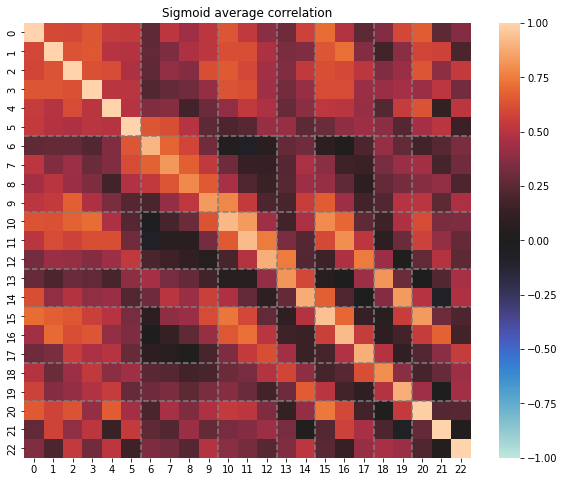

Mean correlation matrix plotted.
This heatmap shows the average correlation between different time steps across all good runs.
The diagonal structure suggests temporal dependencies in the model's representations.


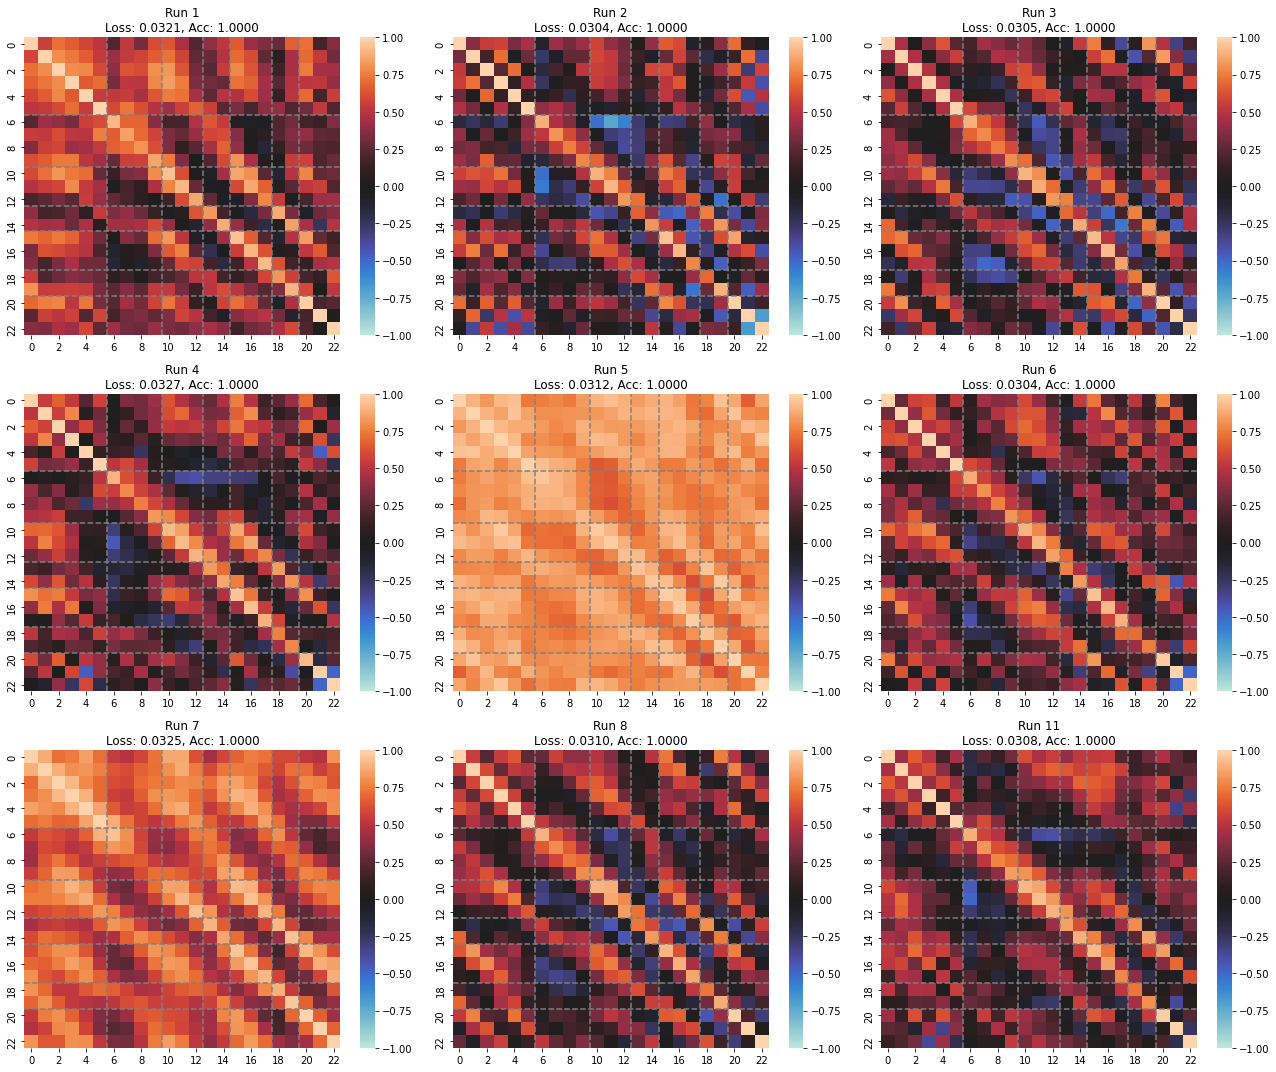

Individual correlation matrices plotted for good runs.
These plots show the variation in correlation patterns across different runs that pass the loss threshold.


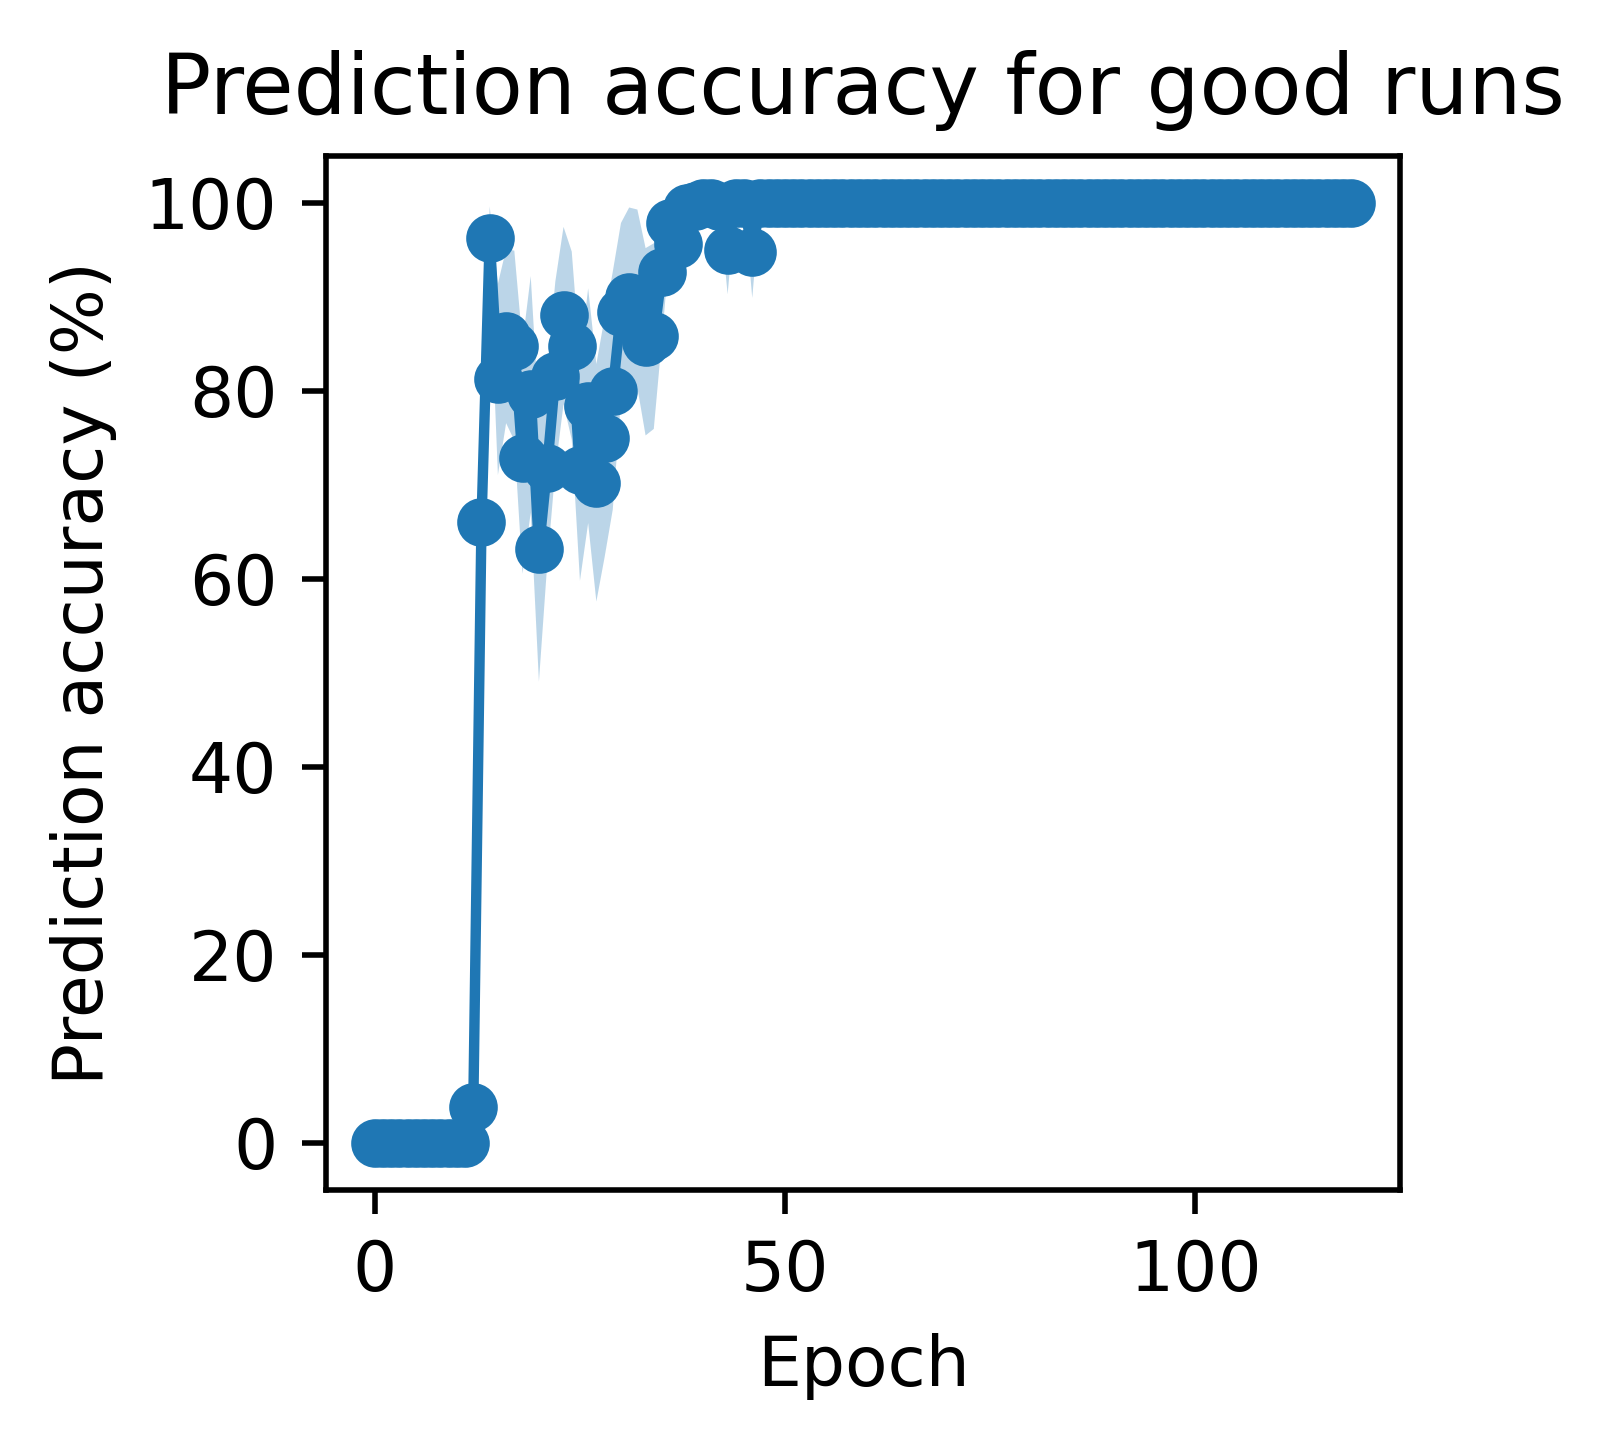

Average accuracy curve plotted for good runs.
Final average accuracy for good runs: 100.00%


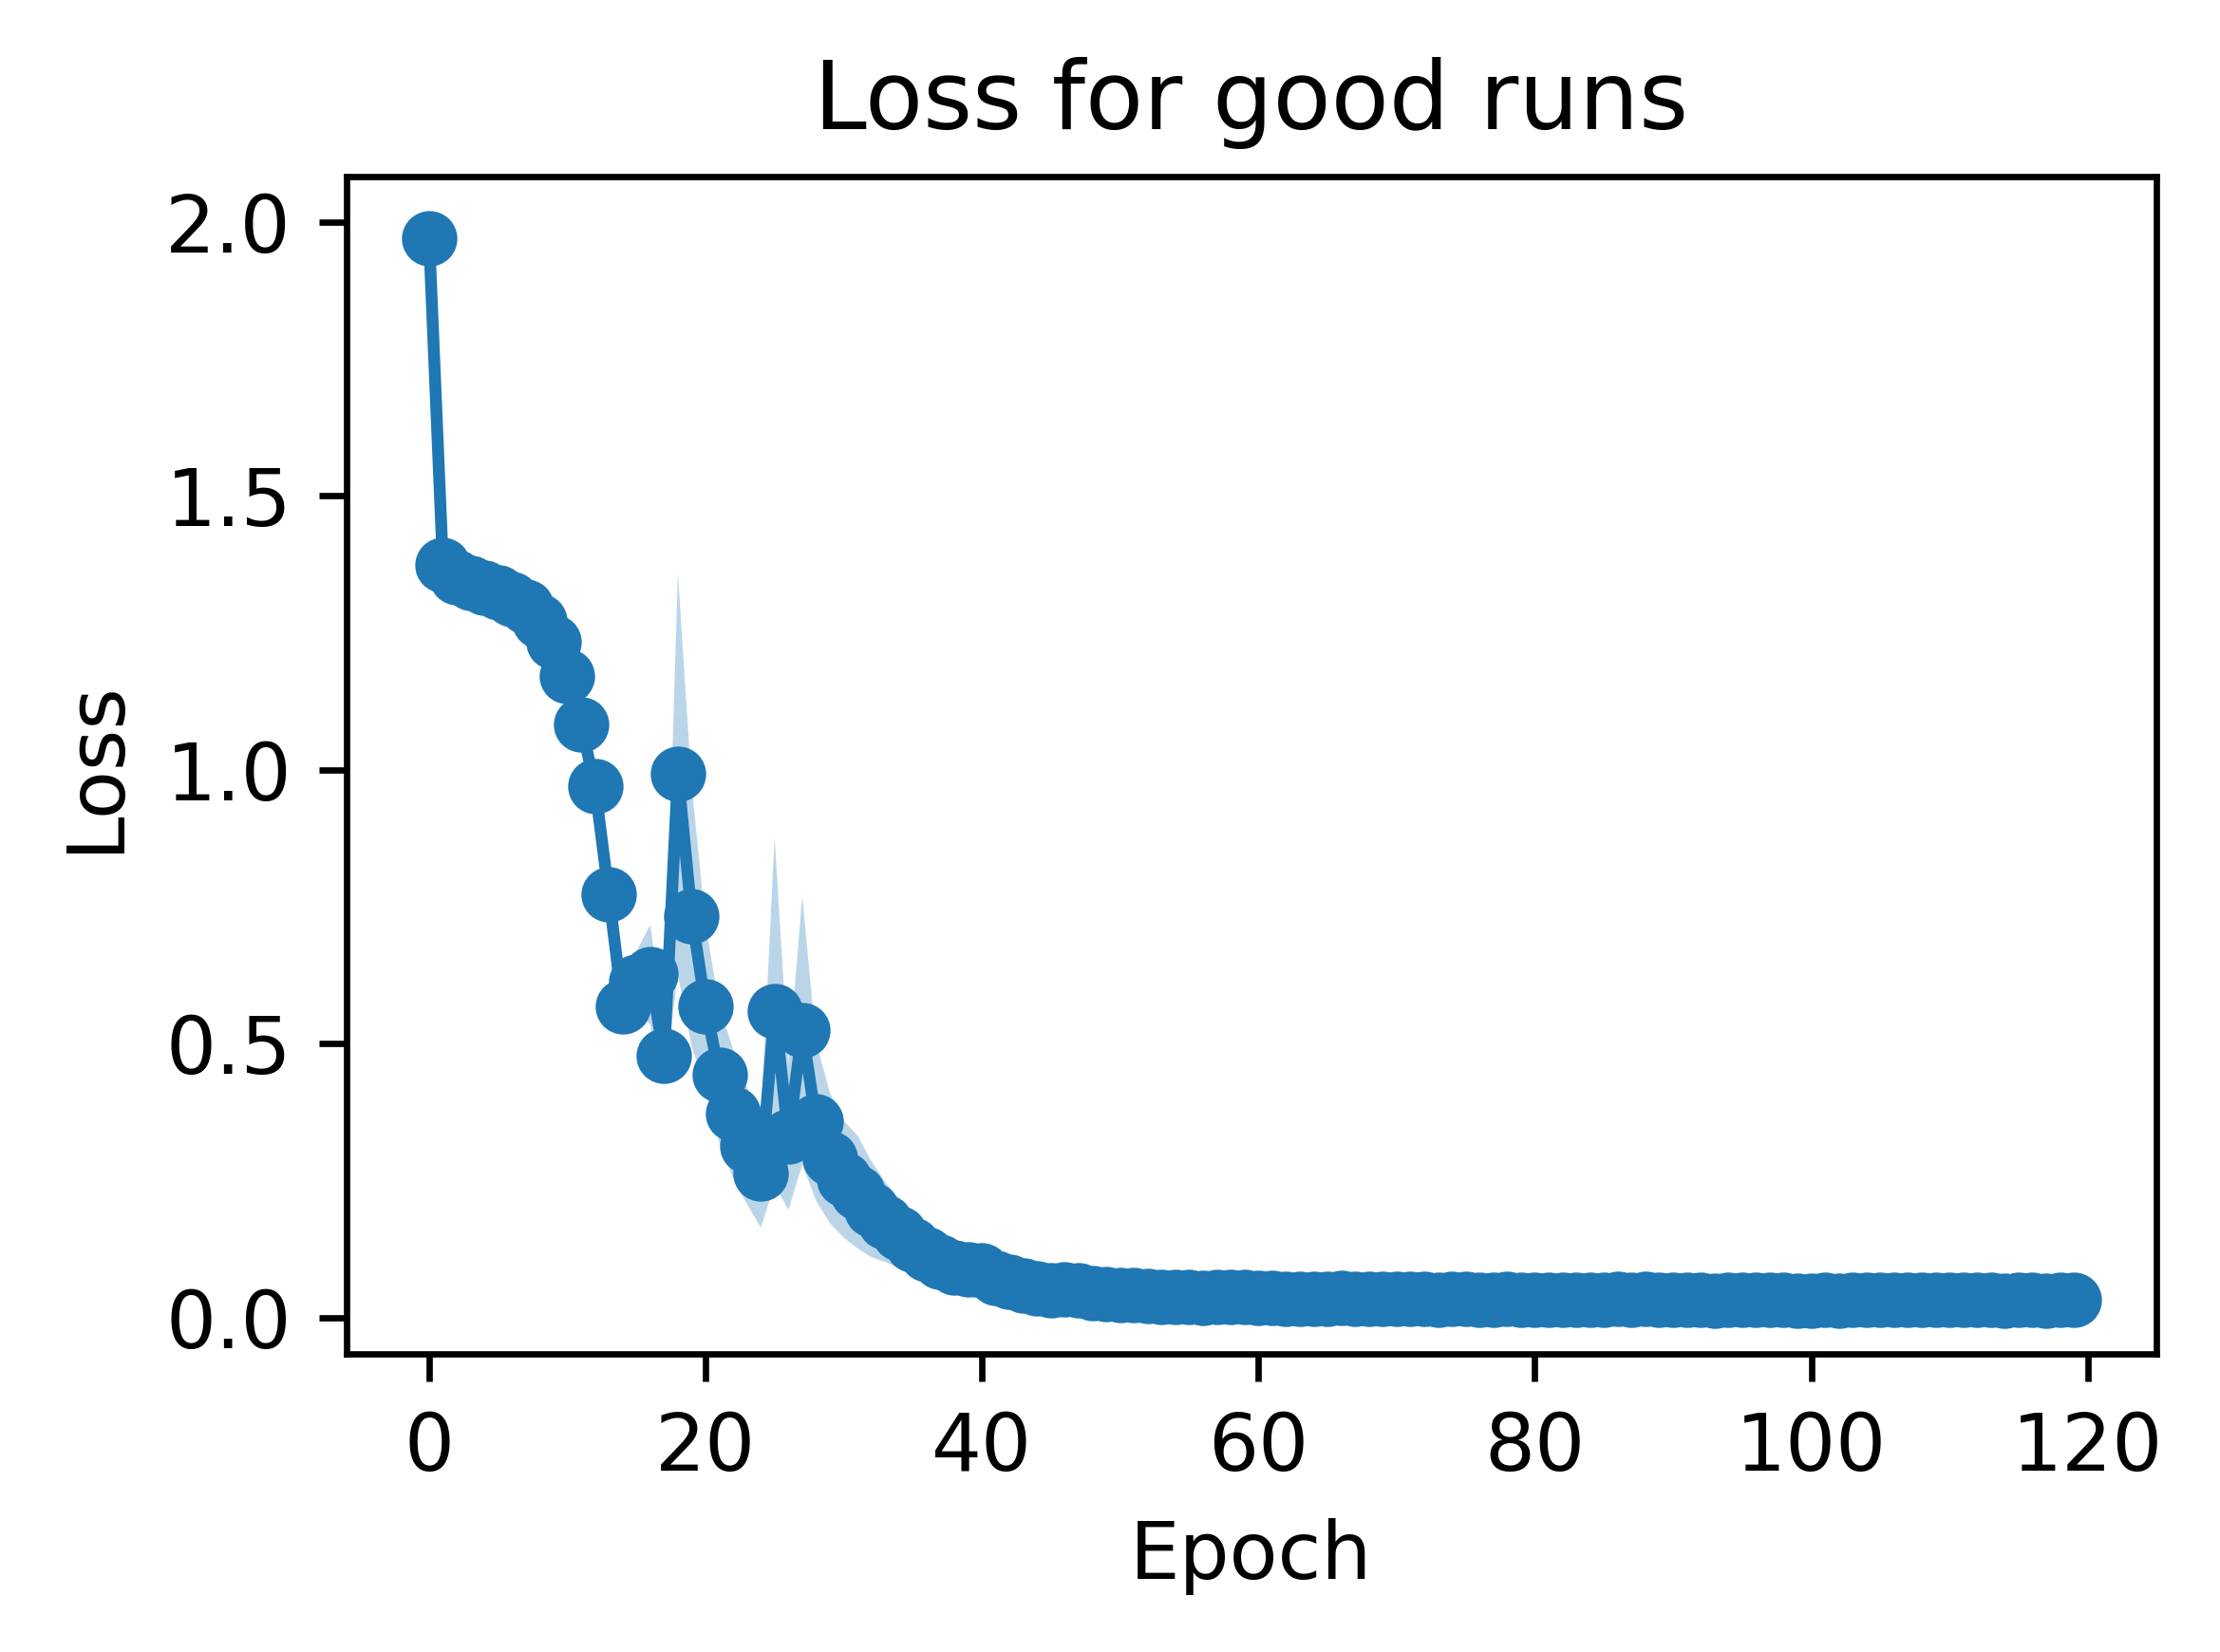

Average loss curve plotted for good runs.
Final average loss for good runs: 0.0315


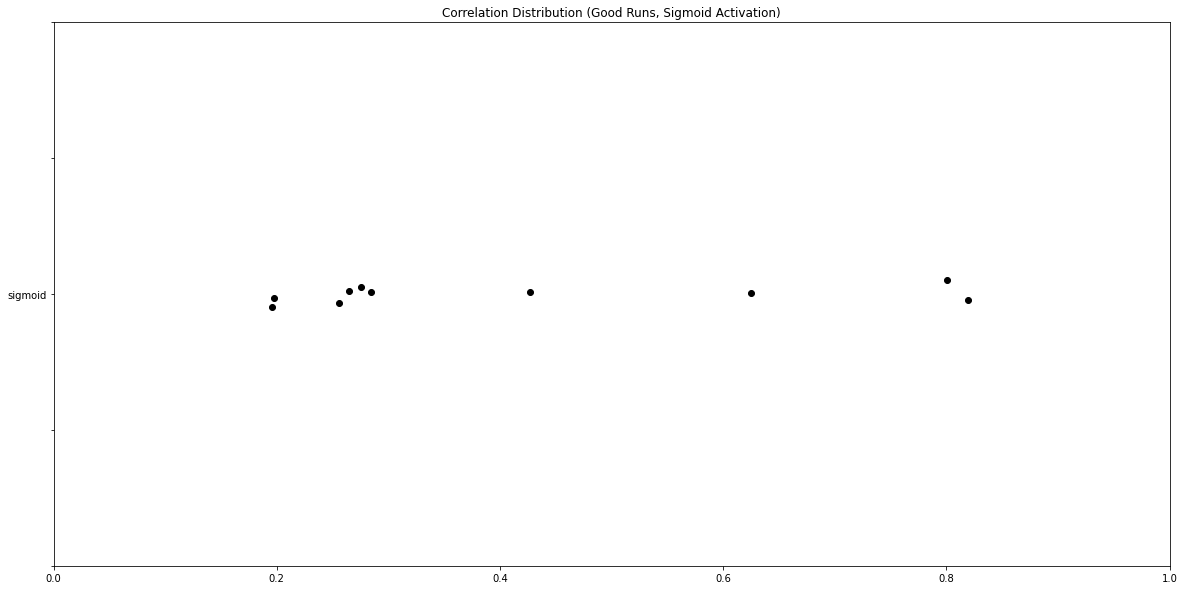

Correlation distribution plotted for good runs.
This plot shows the distribution of mean correlations across good runs.
Mean correlation: 0.4146
Analysis completed.
Summary:
- Total simulations: 12
- Runs with loss < 0.04: 10
- Final mean loss (all runs): 0.1897
- Final mean loss (good runs): 0.0315
- Final mean accuracy (all runs): 87.50%
- Final mean accuracy (good runs): 100.00%
- Mean last-step correlation (good runs): 0.4146


In [12]:
print("\nAnalysis script follows:")
print("=" * 80)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
from datetime import datetime
import math

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

print("Analysis of GPU RNN Model Results (Sigmoid Activation)")
print("="*40)

# Constants
tr_len = 23
loss_thresh = 0.04

# Load data
file_chosen = '2024-08-22-11-33'  # Use the timestamp from the training run
print(f"Loading data from files with timestamp: {file_chosen}")

corr_curve = np.load(f'./sigmoid_corr_curve_{file_chosen}.npy')
accuracy_curve_all_test = np.load(f'./sigmoid_accuracy_curve_all_test_{file_chosen}.npy')
loss_all = np.load(f'./sigmoid_loss_all_{file_chosen}.npy')

print(f"Data loaded successfully.")
print(f"Total number of simulations: {corr_curve.shape[0]}")
print(f"Number of epochs: {corr_curve.shape[1]}")
print(f"Correlation matrix size: {corr_curve.shape[2]}x{corr_curve.shape[3]}")
print("="*40)

# Basic Statistics
print("Basic Statistics:")
print(f"Final mean loss: {np.mean(loss_all[:,-1]):.4f}")
print(f"Final mean accuracy: {np.mean(accuracy_curve_all_test[:,-1]):.4f}")

# Number of runs with good convergence
good_runs = (loss_all[:,-1] < loss_thresh).sum()
print(f"Number of runs with good convergence (loss < {loss_thresh}): {good_runs}")
print(f"Percentage of good runs: {good_runs/loss_all.shape[0]*100:.2f}%")
print("="*40)

# Last time step mean correlation
corr_avg_last_session = np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=(1,2))
print("Last time step mean correlation statistics:")
print(f"Mean: {np.mean(corr_avg_last_session):.4f}")
print(f"Median: {np.median(corr_avg_last_session):.4f}")
print(f"Min: {np.min(corr_avg_last_session):.4f}")
print(f"Max: {np.max(corr_avg_last_session):.4f}")
print("="*40)

print("Generating plots...")

# Plot mean correlation matrix
plt.figure(figsize=(10, 8))
sb.heatmap(np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=0), 
           vmin=-1, vmax=1, cmap='icefire')
for plot_line in [6,10,13,15,18,20]:
    plt.axvline(plot_line, linestyle='--', color='gray')
    plt.axhline(plot_line, linestyle='--', color='gray')
    plt.axvline(plot_line+23, linestyle='--', color='gray')
    plt.axhline(plot_line+23, linestyle='--', color='gray')
plt.title('Sigmoid average correlation')
plt.savefig(f'./sigmoid_avg_correlation_{file_chosen}.png')
plt.show()

print("Mean correlation matrix plotted.")
print("This heatmap shows the average correlation between different time steps across all good runs.")
print("The diagonal structure suggests temporal dependencies in the model's representations.")
print("="*40)

# Plot individual correlation matrices as subplots
good_run_indices = np.where(loss_all[:,-1] < loss_thresh)[0]
n_plots = min(9, len(good_run_indices))
n_rows = math.ceil(n_plots / 3)
n_cols = min(n_plots, 3)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i in range(n_plots):
    sb.heatmap(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][good_run_indices[i],:,:], 
               vmin=-1, vmax=1, cmap='icefire', ax=axes[i])
    for plot_line in [6,10,13,15,18,20]:
        axes[i].axvline(plot_line, linestyle='--', color='gray')
        axes[i].axhline(plot_line, linestyle='--', color='gray')
        axes[i].axvline(plot_line+23, linestyle='--', color='gray')
        axes[i].axhline(plot_line+23, linestyle='--', color='gray')
    axes[i].set_title(f'Run {good_run_indices[i]+1}\nLoss: {loss_all[good_run_indices[i],-1]:.4f}, '
                      f'Acc: {accuracy_curve_all_test[good_run_indices[i],-1]:.4f}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'./sigmoid_individual_correlations_{file_chosen}.png')
plt.show()

print("Individual correlation matrices plotted for good runs.")
print("These plots show the variation in correlation patterns across different runs that pass the loss threshold.")
print("="*40)

# Plot average accuracy curve for good runs
plt.figure(figsize=(3, 3), dpi=500)
A = accuracy_curve_all_test[good_run_indices] * 100
combined_mean = np.mean(A, axis=0)
combined_sem = np.std(A, axis=0) / np.sqrt(A.shape[0])
x = np.arange(A.shape[1])
plt.plot(x, combined_mean, '-o', label='Mean')
plt.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Prediction accuracy (%)')
plt.title('Prediction accuracy for good runs')
plt.tight_layout()
plt.savefig(f'./sigmoid_avg_accuracy_{file_chosen}.pdf', format='pdf', dpi=600)
plt.show()

print("Average accuracy curve plotted for good runs.")
print(f"Final average accuracy for good runs: {np.mean(accuracy_curve_all_test[good_run_indices, -1])*100:.2f}%")
print("="*40)

# Plot average loss curve for good runs
plt.figure(figsize=(4, 3), dpi=600)
L = loss_all[good_run_indices]
combined_mean = np.mean(L, axis=0)
combined_sem = np.std(L, axis=0) / np.sqrt(L.shape[0])
x = np.arange(L.shape[1])
plt.plot(x, combined_mean, '-o', label='Mean')
plt.fill_between(x, combined_mean - combined_sem, combined_mean + combined_sem, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for good runs')
plt.tight_layout()
plt.savefig(f'./sigmoid_avg_loss_{file_chosen}.pdf', format='pdf', dpi=600)
plt.show()

print("Average loss curve plotted for good runs.")
print(f"Final average loss for good runs: {np.mean(loss_all[good_run_indices, -1]):.4f}")
print("="*40)

# Plot correlation distribution for good runs
corr_all = np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][good_run_indices], axis=(1,2))
num_points = len(corr_all)
xjitter = np.random.normal(0, 0.1, num_points)
yall = 6 * np.ones(num_points) + xjitter

fig, axs = plt.subplots(1, figsize=(20, 10))
axs.bar([1], np.mean(corr_all))
axs.plot(corr_all, yall, 'o', color='black')
axs.set_ylim(2, 10)
axs.set_xlim(0, 1)
axs.set_yticks([2, 4, 6, 8, 10], ['', '', 'sigmoid', '', ''])
axs.set_title('Correlation Distribution (Good Runs, Sigmoid Activation)')
plt.savefig(f'./sigmoid_corr_distribution_{file_chosen}.png')
plt.show()

print("Correlation distribution plotted for good runs.")
print("This plot shows the distribution of mean correlations across good runs.")
print(f"Mean correlation: {np.mean(corr_all):.4f}")
print("="*40)

print("Analysis completed.")
print(f"Summary:")
print(f"- Total simulations: {corr_curve.shape[0]}")
print(f"- Runs with loss < {loss_thresh}: {good_runs}")
print(f"- Final mean loss (all runs): {np.mean(loss_all[:,-1]):.4f}")
print(f"- Final mean loss (good runs): {np.mean(loss_all[good_run_indices, -1]):.4f}")
print(f"- Final mean accuracy (all runs): {np.mean(accuracy_curve_all_test[:,-1])*100:.2f}%")
print(f"- Final mean accuracy (good runs): {np.mean(accuracy_curve_all_test[good_run_indices, -1])*100:.2f}%")
print(f"- Mean last-step correlation (good runs): {np.mean(corr_all):.4f}")

In [ ]:
print("\nAnalysis script follows:")
print("=" * 80)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
from datetime import datetime
import math

matplotlib.rcParams['pdf.fonttype'] = 42

print("Analysis of GPU RNN Model Results (Sigmoid Activation)")
print("="*40)

# Constants
tr_len = 23
loss_thresh = 0.04
decorr_thresh = 0.3  # New threshold for decorrelation analysis

# Load data
file_chosen = name_add  # Use the timestamp from the training run
print(f"Loading data from files with timestamp: {file_chosen}")

corr_curve = np.load(f'Sigmoid_RNN_FINAL/sigmoid_corr_curve_{file_chosen}.npy')
accuracy_curve_all_test = np.load(f'Sigmoid_RNN_FINAL/sigmoid_accuracy_curve_all_test_{file_chosen}.npy')
loss_all = np.load(f'Sigmoid_RNN_FINAL/sigmoid_loss_all_{file_chosen}.npy')

print(f"Data loaded successfully.")
print(f"Total number of simulations: {corr_curve.shape[0]}")
print(f"Number of epochs: {corr_curve.shape[1]}")
print(f"Correlation matrix size: {corr_curve.shape[2]}x{corr_curve.shape[3]}")
print("="*40)

# Basic Statistics
print("Basic Statistics:")
print(f"Final mean loss: {np.mean(loss_all[:,-1]):.4f}")
print(f"Final mean accuracy: {np.mean(accuracy_curve_all_test[:,-1]):.4f}")

# Number of runs with good convergence
good_runs = (loss_all[:,-1] < loss_thresh).sum()
print(f"Number of runs with good convergence (loss < {loss_thresh}): {good_runs}")
print(f"Percentage of good runs: {good_runs/loss_all.shape[0]*100:.2f}%")
print("="*40)

# Last time step mean correlation
corr_avg_last_session = np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=(1,2))
print("Last time step mean correlation statistics:")
print(f"Mean: {np.mean(corr_avg_last_session):.4f}")
print(f"Median: {np.median(corr_avg_last_session):.4f}")
print(f"Min: {np.min(corr_avg_last_session):.4f}")
print(f"Max: {np.max(corr_avg_last_session):.4f}")
print("="*40)

print("Generating plots...")
                            
                                                            
# Plot mean correlation matrix
plt.figure(figsize=(10, 8))
sb.heatmap(np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][loss_all[:,-1]<loss_thresh], axis=0), 
           vmin=-1, vmax=1, cmap='icefire')
for plot_line in [6,10,13,15,18,20]:
    plt.axvline(plot_line, linestyle='--', color='gray')
    plt.axhline(plot_line, linestyle='--', color='gray')
    plt.axvline(plot_line+23, linestyle='--', color='gray')
    plt.axhline(plot_line+23, linestyle='--', color='gray')
plt.title('Sigmoid average correlation')
plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_avg_correlation_{file_chosen}.png')
plt.show()

print("Mean correlation matrix plotted.")
print("This heatmap shows the average correlation between different time steps across all good runs.")
print("The diagonal structure suggests temporal dependencies in the model's representations.")
print("="*40)

# Define regions for correlation analysis
regions = [[0, 6], [10, 13], [15, 18], [20, 23]]
other_regions = np.array([10, 13, 14, 15, 18, 19, 20, 23])

# Create correlation matrices
correlation_matrix_1 = np.zeros((tr_len, tr_len))
for i, region_i in enumerate(regions):
    for j, region_j in enumerate(regions):
        if i != j:
            correlation_matrix_1[region_i[0]:region_i[1], region_j[0]:region_j[1]] = 1

correlation_matrix_2 = np.zeros((tr_len, tr_len))
correlation_matrix_2[other_regions[3]:other_regions[5], other_regions[3]:other_regions[5]] = np.eye(other_regions[5] - other_regions[3])

correlation_matrix_3 = np.zeros((tr_len, tr_len))
correlation_matrix_3[other_regions[0]:other_regions[2], other_regions[0]:other_regions[2]] = np.eye(other_regions[2] - other_regions[0])

correlation_matrices = [correlation_matrix_1, correlation_matrix_2, correlation_matrix_3]
correlation_names = ['Off-diagonal', 'Pre-R2', 'Pre-R1']

# Analyze decorrelation
good_run_indices = np.where(loss_all[:,-1] < loss_thresh)[0]
all_masks_matrix = np.full((3, len(good_run_indices), corr_curve.shape[1]), np.nan)

corr_curve_lim = corr_curve[loss_all[:,-1] < loss_thresh]

# Calculate mean values for all regions
for i, session_n in enumerate(range(len(good_run_indices))):
    corr_position_day = corr_curve_lim[session_n][:,0:tr_len, tr_len:2*tr_len]
    for j, mask in enumerate(correlation_matrices):
        mask_array = np.zeros_like(corr_position_day, dtype=bool)
        mask_array += mask.astype(bool)
        masked_a_array = np.ma.masked_array(corr_position_day, mask=~mask_array)
        mean_values_array = masked_a_array.mean(axis=(1, 2))
        all_masks_matrix[j, i, 0:len(mean_values_array)] = mean_values_array

# Additional filtering based on decorrelation threshold
final_means = all_masks_matrix[:, :, -1]
good_decorr_runs = np.all(final_means < decorr_thresh, axis=0)
filtered_indices = good_run_indices[good_decorr_runs]

print(f"Number of runs passing both loss and decorrelation thresholds: {np.sum(good_decorr_runs)}")
print(f"Percentage of good runs passing decorrelation threshold: {np.sum(good_decorr_runs)/len(good_run_indices)*100:.2f}%")

# Plot individual correlation matrices as subplots
n_plots = min(9, np.sum(good_decorr_runs))
n_rows = math.ceil(n_plots / 3)
n_cols = min(n_plots, 3)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i in range(n_plots):
    sb.heatmap(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][filtered_indices[i],:,:], 
               vmin=-1, vmax=1, cmap='icefire', ax=axes[i])
    for plot_line in [6,10,13,15,18,20]:
        axes[i].axvline(plot_line, linestyle='--', color='gray')
        axes[i].axhline(plot_line, linestyle='--', color='gray')
        axes[i].axvline(plot_line+23, linestyle='--', color='gray')
        axes[i].axhline(plot_line+23, linestyle='--', color='gray')
    axes[i].set_title(f'Run {filtered_indices[i]+1}\nLoss: {loss_all[filtered_indices[i],-1]:.4f}, '
                      f'Acc: {accuracy_curve_all_test[filtered_indices[i],-1]:.4f}')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_individual_correlations_{file_chosen}.png')
plt.show()

print("Individual correlation matrices plotted for filtered runs.")
print("These plots show the variation in correlation patterns across different runs that pass both thresholds.")
print("="*40)

# Plot average accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(np.mean(accuracy_curve_all_test[filtered_indices], axis=0))
plt.title('Average Accuracy Curve (Filtered Runs, Sigmoid Activation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_avg_accuracy_{file_chosen}.png')
plt.show()

print("Average accuracy curve plotted for filtered runs.")
print(f"Final average accuracy for filtered runs: {np.mean(accuracy_curve_all_test[filtered_indices, -1]):.4f}")
print("="*40)

# Plot correlation distribution
corr_all = np.mean(corr_curve[:,-1,0:tr_len,tr_len:2*tr_len][filtered_indices], axis=(1,2))
num_points = len(corr_all)
xjitter = np.random.normal(0, 0.1, num_points)
yall = 6 * np.ones(num_points) + xjitter

fig, axs = plt.subplots(1, figsize=(20, 10))
axs.bar([1], np.mean(corr_all))
axs.plot(corr_all, yall, 'o', color='black')
axs.set_ylim(2, 10)
axs.set_xlim(0, 1)
axs.set_yticks([2, 4, 6, 8, 10], ['', '', 'sigmoid', '', ''])
axs.set_title('Correlation Distribution (Filtered Runs, Sigmoid Activation)')
plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_corr_distribution_{file_chosen}.png')
plt.show()

print("Correlation distribution plotted for filtered runs.")
print("This plot shows the distribution of mean correlations across filtered runs.")
print(f"Mean correlation: {np.mean(corr_all):.4f}")
print("="*40)

# Plot correlation matrices
for i, matrix in enumerate(correlation_matrices):
    plt.figure(figsize=(8, 6))
    sb.heatmap(matrix)
    plt.title(f'Correlation Matrix {i+1}: {correlation_names[i]}')
    plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_corr_matrix_{i+1}_{file_chosen}.png')
    plt.show()

print("Correlation matrices plotted.")
print("These matrices show the regions we're interested in analyzing:")
print("Matrix 1: Off-diagonal regions")
print("Matrix 2: Pre-R2 region")
print("Matrix 3: Pre-R1 region")
print("="*40)

# Plot decorrelation analysis for filtered runs
n_iter = 10
subplots_per_fig = 20
num_figures = math.ceil(np.sum(good_decorr_runs) / subplots_per_fig)

for fig_num in range(num_figures):
    start_idx = fig_num * subplots_per_fig
    end_idx = min((fig_num + 1) * subplots_per_fig, np.sum(good_decorr_runs))
    
    n_rows = math.ceil(math.sqrt(end_idx - start_idx))
    n_cols = math.ceil((end_idx - start_idx) / n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), dpi=300)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, session_n in enumerate(range(start_idx, end_idx)):
        for j, mask in enumerate(correlation_matrices):
            mean_values_array = all_masks_matrix[j, good_decorr_runs][session_n]
            axes[i].plot(np.arange(0, len(mean_values_array)*n_iter, n_iter), mean_values_array, 'o-', label=correlation_names[j])
        
        axes[i].set_title(f'Run {filtered_indices[session_n]+1}')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Mean Correlation')
        axes[i].legend()
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.suptitle(f'Decorrelation Analysis (Runs {start_idx+1}-{end_idx} out of {np.sum(good_decorr_runs)} filtered runs)', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_decorrelation_analysis_{fig_num}_{file_chosen}.png')
    plt.show()

print("Decorrelation analysis plots completed.")
print(f"Total figures generated: {num_figures}")
print("These plots show how correlations in different regions change over training epochs for filtered runs.")
print("Each line represents a different region of interest in the correlation matrix.")
print("Decreasing trends indicate successful decorrelation of representations over time.")
print("="*40)

# Plot heatmaps for all masks (filtered runs only)
for m in range(len(correlation_matrices)):
    plt.figure(figsize=(10, 8))
    sb.heatmap(all_masks_matrix[m, good_decorr_runs])
    plt.title(f'Mask {m+1} Heatmap: {correlation_names[m]} (Sigmoid)')
    plt.xlabel('Epoch')
    plt.ylabel('Run')
    plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_mask_heatmap_{m+1}_{file_chosen}.png')
    plt.show()

print("Mask heatmaps plotted for filtered runs.")
print("These heatmaps show the evolution of correlations in different regions across runs and epochs.")
print("="*40)

# Analyze crossing points (filtered runs only)
cross_thresh = 0.3
run_plot = np.array([True] * np.sum(good_decorr_runs))
where_cross = np.zeros((np.sum(good_decorr_runs), len(correlation_matrices)))

for m in range(len(correlation_matrices)):
    for run in range(np.sum(good_decorr_runs)):
        cross_points = np.where(all_masks_matrix[m, good_decorr_runs][run] < cross_thresh)[0]
        if len(cross_points) > 0:
            where_cross[run, m] = cross_points[0]
        else:
            where_cross[run, m] = all_masks_matrix.shape[2]
            run_plot[run] = False

where_cross = where_cross[run_plot]

plt.figure(figsize=(12, 6))
x_plot = np.repeat(np.array([0,1,2])[:,np.newaxis], where_cross.shape[0], axis=1) + np.random.normal(0,0.05,(3,where_cross.shape[0]))
plt.barh([0,1,2], [np.mean(where_cross[:,0]), np.mean(where_cross[:,1]), np.mean(where_cross[:,2])], color='lightblue')
plt.plot(np.vstack((where_cross[:,0], where_cross[:,1], where_cross[:,2])), x_plot, color='gray')
plt.plot(np.vstack((where_cross[:,0], where_cross[:,1], where_cross[:,2])), x_plot, 'o', color='black')
plt.yticks([0,1,2], correlation_names)
plt.title('Crossing Points Analysis (Filtered Runs, Sigmoid Activation)')
plt.xlabel('Epoch')
plt.savefig(f'Sigmoid_RNN_FINAL/sigmoid_crossing_points_{file_chosen}.png')
plt.show()

print("Crossing points analysis completed and plotted for filtered runs.")
print("This plot shows when different regions' correlations cross the threshold of 0.4.")
print(f"Mean crossing epoch for {correlation_names[0]}: {np.mean(where_cross[:,0]):.2f}")
print(f"Mean crossing epoch for {correlation_names[1]}: {np.mean(where_cross[:,1]):.2f}")
print(f"Mean crossing epoch for {correlation_names[2]}: {np.mean(where_cross[:,2]):.2f}")
print("="*40)

print("Analysis completed.")
print(f"Summary:")
print(f"- Total simulations: {corr_curve.shape[0]}")
print(f"- Runs with loss < {loss_thresh}: {good_runs}")
print(f"- Runs passing both loss and decorrelation thresholds: {np.sum(good_decorr_runs)}")
print(f"- Final mean loss (all runs): {np.mean(loss_all[:,-1]):.4f}")
print(f"- Final mean loss (filtered runs): {np.mean(loss_all[filtered_indices, -1]):.4f}")
print(f"- Final mean accuracy (all runs): {np.mean(accuracy_curve_all_test[:,-1]):.4f}")
print(f"- Final mean accuracy (filtered runs): {np.mean(accuracy_curve_all_test[filtered_indices, -1]):.4f}")
print(f"- Mean last-step correlation (filtered runs): {np.mean(corr_all):.4f}")

In [17]:
import seaborn as sns
import datetime

# Assuming corr_curve is already loaded and has shape (num_replicates, num_epochs, 23, 23)

# 1. Extract the last frame for each replicate
last_frames = corr_curve[:, -1,0:tr_len,tr_len:2*tr_len]  # Shape: (num_replicates, 23, 23)

# 2. Calculate the mean across replicates
mean_last_frame = np.mean(last_frames, axis=0)  # Shape: (23, 23)

# 3. Calculate the overall mean for the entire covariance matrix
overall_mean = np.mean(last_frames)  # Single scalar value

# 4. Calculate the individual means for each replicate
individual_means = np.mean(last_frames, axis=(1,2))  # Shape: (num_replicates,)

# 5. Calculate the SEM
sem = np.std(individual_means) / np.sqrt(len(individual_means))  # Single scalar value

print(f"Overall mean of the last frame covariance matrix: {overall_mean}")
print(f"SEM: {sem}")
individual_means

Overall mean of the last frame covariance matrix: 0.5118763512861503
SEM: 0.08757431899295655


array([0.42705144, 0.19785494, 0.1958311 , 0.27576551, 0.81954483,
       0.2841871 , 0.62480322, 0.25572008, 0.99803062, 0.99897323,
       0.26440759, 0.80034655])

Overall mean of the last frame covariance matrix: 0.5118763512861503
SEM: 0.08757431899295655


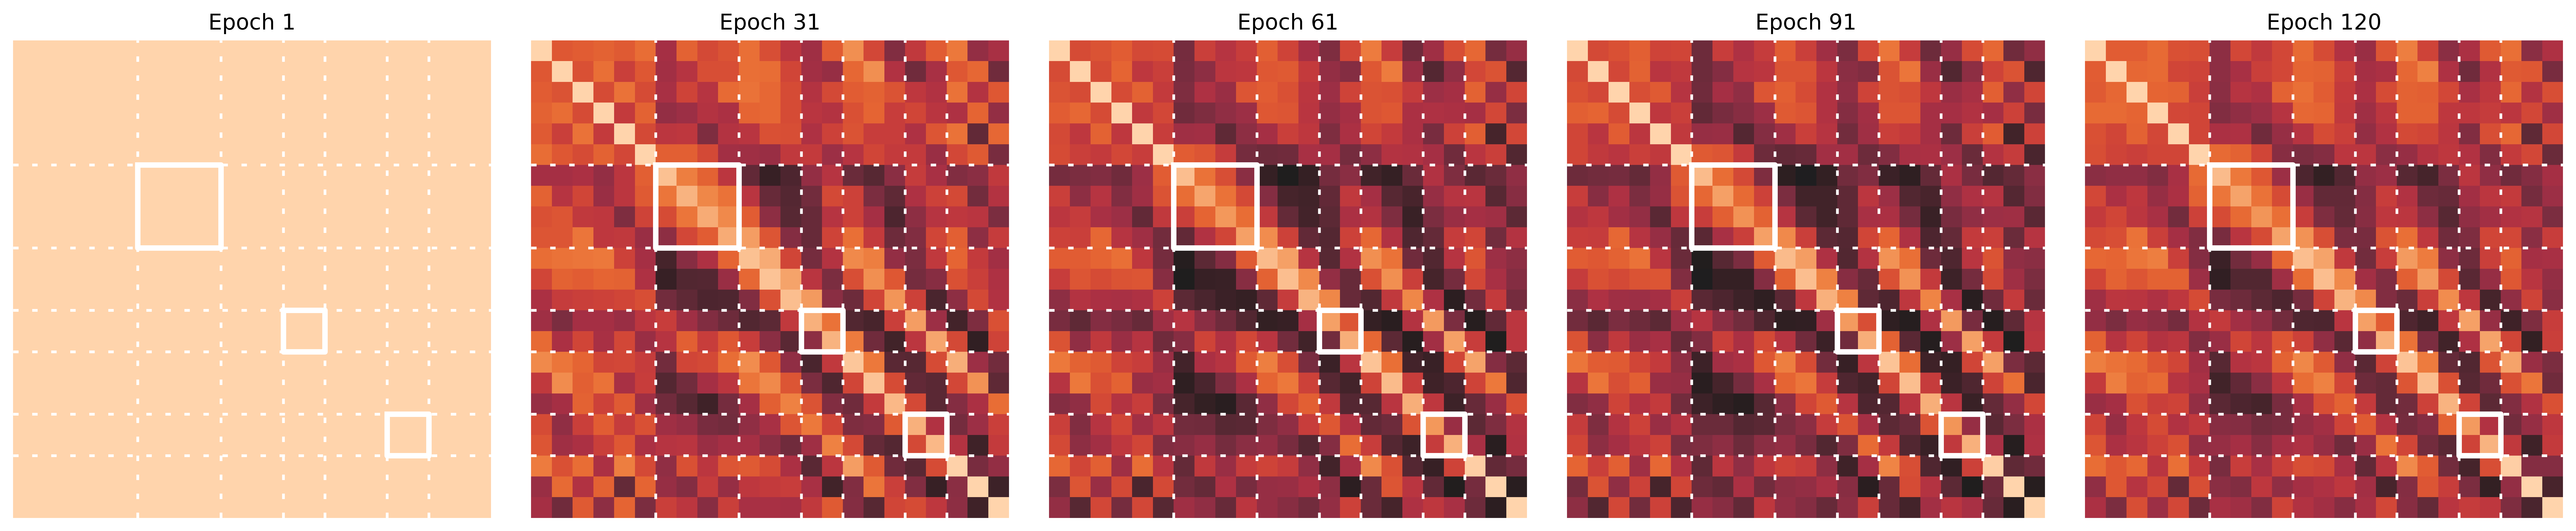

In [16]:
# Calculate mean across replicates
mean_corr_curve = np.mean(corr_curve[:, :,0:tr_len,tr_len:2*tr_len], axis=0)

# Choose 5 epochs to visualize, including the last one
num_epochs = mean_corr_curve.shape[0]
epochs_to_plot = [0, num_epochs // 4, num_epochs // 2, 3 * num_epochs // 4, num_epochs - 1]

# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4), dpi=600)
for i, epoch in enumerate(epochs_to_plot):
    sns.heatmap(mean_corr_curve[epoch], cmap='icefire', vmin=-1, vmax=1, ax=axs[i], 
                cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
    axs[i].set_aspect('equal')  # make each subplot square
    axs[i].set_title(f'Epoch {epoch + 1}')
    # Loop for dotted lines
    for lines in [6, 10, 13, 15, 18, 20]:  
        axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted vertical lines
        axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted horizontal lines
    # Draw square bounding box
    for (low, high) in [(6, 10), (13, 15), (18, 20)]:
        axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white', linewidth=3)  
plt.tight_layout()
today = datetime.datetime.now().strftime('%Y_%m_%d')  # get today's date
plt.savefig(f'Sigmoid_RNN_corr_plot_{today}.pdf', format='pdf', dpi=600)
plt.show()

In [15]:
individual_means

array([0.42705144, 0.19785494, 0.1958311 , 0.27576551, 0.81954483,
       0.2841871 , 0.62480322, 0.25572008, 0.99803062, 0.99897323,
       0.26440759, 0.80034655])